In [ ]:

cheapest_history: list[tuple[list[int],list[tuple[int,int,list[int]]],int]] = []
from tsp.core.tsp import TSP
from tsp.core.solvers import pyramid_solve   
from tsp.experiment.batch_solver import solve_batch
from tsp.experiment.batch import save_problem_batch
import numpy.random as random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import json

cities = TSP.generate_random(50, w=500, h=500)
save_problem_batch([cities], 'pyramid_test/problems')

def pyramid_solve_2_4(problem):
    return pyramid_solve(problem, k=3, s=2)
solve_batch('pyramid_test/problems', pyramid_solve_2_4, 'pyramid_test/pyr_solutions')

def load_tsp_coords(fp):
    with open(fp,'r') as f:
        return np.array(json.load(f)["cities"])

coords = load_tsp_coords("pyramid_test/problems/001.tsp")
num_cities = coords.shape[0]
print("Coords shape:", coords.shape)

tsp_problem = TSP.from_cities(coords, w=500, h=500)
centroids = [ np.array(pt, dtype=float) for pt in coords ]
full_nodes     = list(range(num_cities))

def tour_length(tour: list[int]) -> float:
    idxs   = tour + [tour[0]]
    pts    = coords[idxs]
    deltas = pts[1:] - pts[:-1]
    return np.hypot(deltas[:,0], deltas[:,1]).sum()

history = []  

def recorded_pyramid_insertion(centroids: list[np.ndarray], full_nodes: list[int], k: int, s: int) -> list[int]:
    tour = []                
    inserted = []  

    clusters = [ full_nodes[i:i+k] 
                 for i in range(0, len(full_nodes), k) ]

    for cluster in clusters:
        if not tour:
            tour = cluster.copy()
            inserted.extend(cluster)
            continue

        step_cands = []
        for city in cluster:
            for pos in range(len(tour)+1):
                cand = tour[:pos] + [city] + tour[pos:]
                length = tour_length(cand) 
                step_cands.append((city, pos, cand, length))

        step_cands.sort(key=lambda x: x[3])
        city,pos,tour,_ = step_cands[0] 

        cheapest_history.append((tour.copy(), step_cands, 0))
        inserted.append(city)

        context = inserted[-s:]
    return tour


cheapest_history.clear()
final_tour = recorded_pyramid_insertion(centroids, full_nodes, k=3, s=2)
print("Recorded steps:", len(cheapest_history))

Coords shape: (50, 2)
Recorded steps: 16


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
plt.rcParams['animation.html'] = 'jshtml'
tour_coords = coords[tour + [tour[0]]]
fig, ax = plt.subplots(figsize=(6, 6))
line, = ax.plot([], [], 'k-', lw=2)
points = ax.plot(coords[:, 0], coords[:, 1], 'ro')[0]

ax.set_xlim(0, 500)
ax.set_ylim(0, 500)
ax.set_title("Animated Pyramid Tour")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.grid(True)
ax.set_aspect('equal')

def init():
    line.set_data([], [])
    return line, points

def update(frame):
    x = tour_coords[:frame+1, 0]
    y = tour_coords[:frame+1, 1]
    line.set_data(x, y)
    return line, points
from IPython.display import HTML

ani = animation.FuncAnimation(
    fig, update, frames=len(tour_coords), init_func=init,
    interval=120, blit=True, repeat=False
)
HTML(ani.to_jshtml())
plt.show()
ani.save("pyramid_tour1.gif", writer="pillow", fps=10)



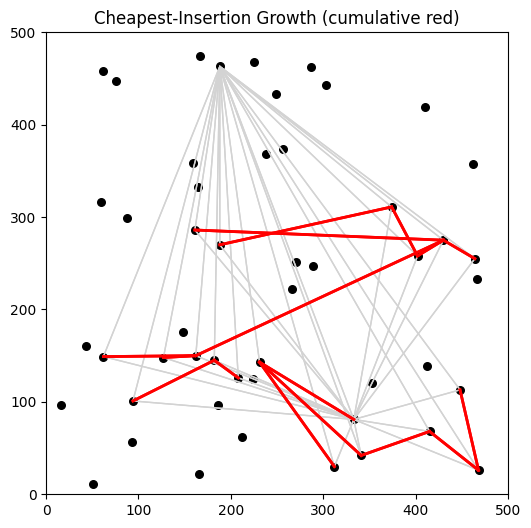

In [ ]:

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

all_cand_segs, chosen_segs = [], []
for tour_before, step_cands, best_idx in cheapest_history:
    step_segs = []
    for city, pos, cand, length in step_cands:
        prev_city = tour_before[pos-1] if pos>0 else tour_before[-1]
        next_city = tour_before[pos] if pos < len(tour_before) else tour_before[0]
        pts = np.vstack([ coords[prev_city], coords[city], coords[next_city] ])
        step_segs.append(pts)
    all_cand_segs.append(step_segs)
    
    city, pos, cand, length = step_cands[best_idx]
    prev_city = tour_before[pos-1] if pos>0 else tour_before[-1]
    next_city = tour_before[pos] if pos < len(tour_before) else tour_before[0]
    chosen_segs.append(np.vstack([
        coords[prev_city],
        coords[city],
        coords[next_city]
    ]))


fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(coords[:,0], coords[:,1], s=30, color="black")
ax.set(xlim=(0,500), ylim=(0,500), aspect="equal",
       title="Cheapest‑Insertion Growth (cumulative red)")

max_cands = max(len(s) for s in all_cand_segs)

gray_lines = [ ax.plot([],[], lw=1, color="lightgray")[0]
        for _ in range(max_cands) ]


red_lines: list[plt.Line2D] = []

def init():
    for ln in gray_lines:
        ln.set_data([],[])

    return gray_lines + red_lines

def update(i):

    for ln, seg in zip(gray_lines, all_cand_segs[i]):
        ln.set_data(seg[:,0], seg[:,1])
    for ln in gray_lines[len(all_cand_segs[i]):]:
        ln.set_data([],[])


    seg = chosen_segs[i]
    new_red, = ax.plot(seg[:,0], seg[:,1], lw=2, color="red")
    red_lines.append(new_red)

    return gray_lines + red_lines

ani = animation.FuncAnimation(
    fig, update,
    frames=len(cheapest_history),
    init_func=init,
    interval=200,
    blit=True,
    repeat=False
)

HTML(ani.to_jshtml())
ani.save("cheapest_growth1.gif", writer="pillow", fps=5)

